## Setting up TPU

In [ ]:
# in order to use TPU you have to run this cell before importing JAX
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

In [ ]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

tpu


In [ ]:
import jax
import jax.numpy as jnp

In [ ]:
jax.local_devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

## Different ways to vectorize a function

In [ ]:
def dot(v1, v2):
  return jnp.vdot(v1, v2)

In [ ]:
dot(jnp.array([1., 1., 1.]), jnp.array([1., 2., -1]))

DeviceArray(2., dtype=float32)

Generate some random arrays

In [ ]:
from jax import random

In [ ]:
rng_key = random.PRNGKey(42)

In [ ]:
vs = random.normal(rng_key, shape=(20,3))

In [ ]:
v1s = vs[:10,:]
v2s = vs[10:,:]

In [ ]:
v1s.shape, v2s.shape

((10, 3), (10, 3))

Naively apply our function to arrays:

In [ ]:
dot(v1s, v2s)

DeviceArray(1.0755965, dtype=float32)

The result is not what we expected.

A naive and correct approach to apply our function to arrays:

In [ ]:
[dot(v1s[i],v2s[i]) for i in range(v1s.shape[0])]

[DeviceArray(-0.9443626, dtype=float32),
 DeviceArray(0.8561607, dtype=float32),
 DeviceArray(-0.45202938, dtype=float32),
 DeviceArray(0.7629303, dtype=float32),
 DeviceArray(-2.06525, dtype=float32),
 DeviceArray(0.5056444, dtype=float32),
 DeviceArray(-0.5623387, dtype=float32),
 DeviceArray(1.5973439, dtype=float32),
 DeviceArray(1.7121218, dtype=float32),
 DeviceArray(-0.33462408, dtype=float32)]

Manually vectorized function:

In [ ]:
def dot_vectorized(v1s, v2s):
  return jnp.einsum('ij,ij->i',v1s, v2s)

In [ ]:
dot_vectorized(v1s, v2s)

DeviceArray([-0.9443626 ,  0.8561607 , -0.45202938,  0.7629303 ,
             -2.06525   ,  0.5056444 , -0.5623387 ,  1.5973439 ,
              1.7121218 , -0.33462408], dtype=float32)

Automatically vectorized function:

In [ ]:
dot_vmapped = jax.vmap(dot)

In [ ]:
dot_vmapped(v1s, v2s)

DeviceArray([-0.9443626 ,  0.8561607 , -0.45202938,  0.7629303 ,
             -2.06525   ,  0.5056444 , -0.5623387 ,  1.5973439 ,
              1.7121218 , -0.33462408], dtype=float32)

Let's compare the speed of different approaches:

In [ ]:
%timeit [dot(v1s[i],v2s[i]).block_until_ready() for i in range(v1s.shape[0])]

127 ms ± 22.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit dot_vectorized(v1s, v2s).block_until_ready()

2.71 ms ± 273 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit dot_vmapped(v1s, v2s).block_until_ready()

3.33 ms ± 449 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
dot_vectorized_jitted = jax.jit(dot_vectorized)
dot_vmapped_jitted = jax.jit(dot_vmapped)

# warm-up
dot_vectorized_jitted(v1s, v2s);
dot_vmapped_jitted(v1s, v2s);

In [ ]:
%timeit dot_vectorized_jitted(v1s, v2s).block_until_ready()

2.55 ms ± 415 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit dot_vmapped_jitted(v1s, v2s).block_until_ready()

2.31 ms ± 369 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Let's look at the internals of the function:

In [ ]:
jax.make_jaxpr(dot)(jnp.array([1., 1., 1.]), jnp.array([1., 1., -1]))

{ lambda ; a:f32[3] b:f32[3]. let
    c:f32[] = dot_general[
      dimension_numbers=(((0,), (0,)), ((), ()))
      precision=None
      preferred_element_type=None
    ] a b
  in (c,) }

In [ ]:
jax.make_jaxpr(dot_vectorized)(v1s, v2s)

{ lambda ; a:f32[10,3] b:f32[10,3]. let
    c:f32[10] = xla_call[
      call_jaxpr={ lambda ; d:f32[10,3] e:f32[10,3]. let
          f:f32[10] = dot_general[
            dimension_numbers=(((1,), (1,)), ((0,), (0,)))
            precision=None
            preferred_element_type=None
          ] d e
        in (f,) }
      name=_einsum
    ] a b
  in (c,) }

In [ ]:
jax.make_jaxpr(dot_vmapped)(v1s, v2s)

{ lambda ; a:f32[10,3] b:f32[10,3]. let
    c:f32[10] = dot_general[
      dimension_numbers=(((1,), (1,)), ((0,), (0,)))
      precision=None
      preferred_element_type=None
    ] a b
  in (c,) }

## Controlling vmap() behavior

### Using in_axes parameter

A default value:

In [ ]:
dot_vmapped = jax.vmap(dot, in_axes=(0,0))

In [ ]:
dot_vmapped(v1s, v2s)

DeviceArray([-0.9443626 ,  0.8561607 , -0.45202938,  0.7629303 ,
             -2.06525   ,  0.5056444 , -0.5623387 ,  1.5973439 ,
              1.7121218 , -0.33462408], dtype=float32)

A more complicated case:

In [ ]:
def scaled_dot(v1, v2, koeff):
  return koeff*jnp.vdot(v1, v2)

In [ ]:
v1s_ = v1s
v2s_ = v2s.T
k = 1.0

In [ ]:
v1s_.shape, v2s_.shape

((10, 3), (3, 10))

In [ ]:
scaled_dot_batched = jax.vmap(scaled_dot)

Default values do not work:

In [ ]:
scaled_dot_batched(v1s_, v2s_, k)

ValueError: ignored

In [ ]:
scaled_dot_batched = jax.vmap(scaled_dot, in_axes=(0,1,None))

In [ ]:
scaled_dot_batched(v1s_, v2s_, k)

DeviceArray([-0.9443626 ,  0.8561607 , -0.45202938,  0.7629303 ,
             -2.06525   ,  0.5056444 , -0.5623387 ,  1.5973439 ,
              1.7121218 , -0.33462408], dtype=float32)

Using more complex parameter structure:

In [ ]:
def scaled_dot(data, koeff):
  return koeff*jnp.vdot(data['a'], data['b'])

In [ ]:
scaled_dot_batched = jax.vmap(scaled_dot, in_axes=({'a':0,'b':1},None))

In [ ]:
scaled_dot_batched({'a':v1s_, 'b': v2s_}, k)

DeviceArray([-0.9443626 ,  0.8561607 , -0.45202938,  0.7629303 ,
             -2.06525   ,  0.5056444 , -0.5623387 ,  1.5973439 ,
              1.7121218 , -0.33462408], dtype=float32)

### Using out_axes parameter

In [ ]:
def scale(v, koeff):
  return koeff*v

In [ ]:
scale_batched = jax.vmap(scale, 
                         in_axes=(0,None), 
                         out_axes=(1))

In [ ]:
scale_batched(v1s, 2.0)

DeviceArray([[-1.4672164 , -1.6510313 ,  3.5308475 , -2.2189069 ,
               0.30244178,  0.7649356 , -4.028745  , -3.0968459 ,
               0.34476116, -2.9087389 ],
             [-1.5357224 , -0.7061164 ,  4.008241  , -0.69232005,
              -3.2186432 ,  2.0812016 ,  3.5850892 ,  0.15288436,
               2.0001264 ,  2.024669  ],
             [-1.6229192 ,  1.5497079 , -3.2013686 ,  0.5012715 ,
              -0.2000112 ,  1.6244583 ,  0.17156784, -1.31133   ,
              -2.5324473 , -1.605759  ]], dtype=float32)

In [ ]:
scale_batched = jax.vmap(scale, in_axes=(0,None))

In [ ]:
scale_batched(v1s, 2.0)

DeviceArray([[-1.4672164 , -1.5357224 , -1.6229192 ],
             [-1.6510313 , -0.7061164 ,  1.5497079 ],
             [ 3.5308475 ,  4.008241  , -3.2013686 ],
             [-2.2189069 , -0.69232005,  0.5012715 ],
             [ 0.30244178, -3.2186432 , -0.2000112 ],
             [ 0.7649356 ,  2.0812016 ,  1.6244583 ],
             [-4.028745  ,  3.5850892 ,  0.17156784],
             [-3.0968459 ,  0.15288436, -1.31133   ],
             [ 0.34476116,  2.0001264 , -2.5324473 ],
             [-2.9087389 ,  2.024669  , -1.605759  ]], dtype=float32)

### Using with named (keyword) arguments

In [ ]:
def scale(v, koeff=1.0):
  return koeff*v

In [ ]:
scale_batched = jax.vmap(scale,
                         in_axes=(0,None), 
                         out_axes=(1))

In [ ]:
scale_batched(v1s, koeff=2.0) 

AssertionError: ignored

In [ ]:
scale_batched = jax.vmap(scale,
                         in_axes=(0), 
                         out_axes=(1))

In [ ]:
scale_batched(v1s, koeff=2.0) 

ValueError: ignored

In [ ]:
from functools import partial

In [ ]:
scale2 = partial(scale, koeff=2.0)

In [ ]:
scale_batched = jax.vmap(scale2,
                         in_axes=(0), 
                         out_axes=(1))

In [ ]:
scale_batched(v1s) 

DeviceArray([[-1.4672164 , -1.6510313 ,  3.5308475 , -2.2189069 ,
               0.30244178,  0.7649356 , -4.028745  , -3.0968459 ,
               0.34476116, -2.9087389 ],
             [-1.5357224 , -0.7061164 ,  4.008241  , -0.69232005,
              -3.2186432 ,  2.0812016 ,  3.5850892 ,  0.15288436,
               2.0001264 ,  2.024669  ],
             [-1.6229192 ,  1.5497079 , -3.2013686 ,  0.5012715 ,
              -0.2000112 ,  1.6244583 ,  0.17156784, -1.31133   ,
              -2.5324473 , -1.605759  ]], dtype=float32)

In [ ]:
scale_batched = jax.vmap(scale,
                         in_axes=(0), 
                         out_axes=(1))

In [ ]:
scale_batched(v1s, koeff=jnp.broadcast_to(2.0, (v1s.shape[0],)))

DeviceArray([[-1.4672164 , -1.6510313 ,  3.5308475 , -2.2189069 ,
               0.30244178,  0.7649356 , -4.028745  , -3.0968459 ,
               0.34476116, -2.9087389 ],
             [-1.5357224 , -0.7061164 ,  4.008241  , -0.69232005,
              -3.2186432 ,  2.0812016 ,  3.5850892 ,  0.15288436,
               2.0001264 ,  2.024669  ],
             [-1.6229192 ,  1.5497079 , -3.2013686 ,  0.5012715 ,
              -0.2000112 ,  1.6244583 ,  0.17156784, -1.31133   ,
              -2.5324473 , -1.605759  ]], dtype=float32)

### Using decorator style

In [ ]:
from functools import partial

In [ ]:
@partial(jax.vmap, in_axes=(0,None), out_axes=(1))
def scale(v, koeff):
  return koeff*v

In [ ]:
scale(v1s, 2.0)

DeviceArray([[-1.4672164 , -1.6510313 ,  3.5308475 , -2.2189069 ,
               0.30244178,  0.7649356 , -4.028745  , -3.0968459 ,
               0.34476116, -2.9087389 ],
             [-1.5357224 , -0.7061164 ,  4.008241  , -0.69232005,
              -3.2186432 ,  2.0812016 ,  3.5850892 ,  0.15288436,
               2.0001264 ,  2.024669  ],
             [-1.6229192 ,  1.5497079 , -3.2013686 ,  0.5012715 ,
              -0.2000112 ,  1.6244583 ,  0.17156784, -1.31133   ,
              -2.5324473 , -1.605759  ]], dtype=float32)

### Using axis_name parameter

In [ ]:
arr = jnp.array(range(50))

In [ ]:
arr

DeviceArray([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
             15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
             30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
             45, 46, 47, 48, 49], dtype=int32)

In [ ]:
norm = jax.vmap(
    lambda x: x/jax.lax.psum(x, axis_name='batch'),
    axis_name='batch')

In [ ]:
norm(arr)

DeviceArray([0.        , 0.00081633, 0.00163265, 0.00244898, 0.00326531,
             0.00408163, 0.00489796, 0.00571429, 0.00653061, 0.00734694,
             0.00816326, 0.00897959, 0.00979592, 0.01061224, 0.01142857,
             0.0122449 , 0.01306122, 0.01387755, 0.01469388, 0.0155102 ,
             0.01632653, 0.01714286, 0.01795918, 0.01877551, 0.01959183,
             0.02040816, 0.02122449, 0.02204081, 0.02285714, 0.02367347,
             0.02448979, 0.02530612, 0.02612245, 0.02693877, 0.0277551 ,
             0.02857143, 0.02938775, 0.03020408, 0.03102041, 0.03183673,
             0.03265306, 0.03346939, 0.03428571, 0.03510204, 0.03591837,
             0.03673469, 0.03755102, 0.03836735, 0.03918367, 0.04      ],            dtype=float32)

In [ ]:
jnp.sum(norm(arr))

DeviceArray(1., dtype=float32)

In [ ]:
norm = jax.vmap(lambda x: (x-jax.lax.pmin(x, axis_name='i'))/(jax.lax.pmax(x, axis_name='i') - jax.lax.pmin(x, axis_name='i')), axis_name='i')

In [ ]:
norm(arr)

DeviceArray([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163266,
             0.10204083, 0.12244899, 0.14285715, 0.16326532, 0.18367349,
             0.20408165, 0.22448981, 0.24489798, 0.26530614, 0.2857143 ,
             0.30612248, 0.32653064, 0.3469388 , 0.36734697, 0.38775513,
             0.4081633 , 0.42857146, 0.44897962, 0.4693878 , 0.48979595,
             0.51020414, 0.5306123 , 0.55102044, 0.5714286 , 0.59183675,
             0.61224496, 0.6326531 , 0.6530613 , 0.6734694 , 0.6938776 ,
             0.7142858 , 0.73469394, 0.7551021 , 0.77551025, 0.7959184 ,
             0.8163266 , 0.8367348 , 0.8571429 , 0.8775511 , 0.89795923,
             0.9183674 , 0.9387756 , 0.95918375, 0.9795919 , 1.0000001 ],            dtype=float32)

In [ ]:
jax.make_jaxpr(norm)(arr)

{ lambda ; a:i32[50]. let
    b:i32[] = pmin[axes=(0,) axis_index_groups=None] a
    c:i32[50] = sub a b
    d:i32[] = pmax[axes=(0,) axis_index_groups=None] a
    e:i32[] = pmin[axes=(0,) axis_index_groups=None] a
    f:i32[] = sub d e
    g:f32[50] = convert_element_type[new_dtype=float32 weak_type=False] c
    h:f32[] = convert_element_type[new_dtype=float32 weak_type=False] f
    i:f32[50] = div g h
  in (i,) }

## More real-life cases

### Batch data processing

In [ ]:
import jax
import jax.numpy as jnp
from jax import lax
from jax import random

In [ ]:
add_noise_func = lambda x: x+10
horizontal_flip_func = lambda x: x+1
rotate_func = lambda x: x+2
adjust_colors_func = lambda x: x+3

augmentations = [
   add_noise_func,
   horizontal_flip_func,
   rotate_func,
   adjust_colors_func
]

In [ ]:
image = jnp.array(range(100))

In [ ]:
def random_augmentation(image, augmentations, rng_key):
   '''A function that applies a random transformation to an image'''
   augmentation_index = random.randint(key=rng_key, minval=0, maxval=len(augmentations), shape=())
   augmented_image = lax.switch(augmentation_index, augmentations, image)
   return augmented_image

In [ ]:
random_augmentation(image, augmentations, random.PRNGKey(211))

DeviceArray([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
              13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
              25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
              37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
              49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
              61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
              73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
              85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
              97,  98,  99, 100], dtype=int32)

In [ ]:
images = jnp.repeat(jnp.reshape(image, (1,len(image))), 10, axis=0)
images.shape

(10, 100)

In [ ]:
random.PRNGKey(211)

DeviceArray([  0, 211], dtype=uint32)

In [ ]:
rng_keys = random.split(random.PRNGKey(211), num=len(images))

In [ ]:
rng_keys

DeviceArray([[3650472307, 3607347749],
             [1737802500, 2401109662],
             [2280781916, 1639365058],
             [3067911487, 1292196730],
             [2582374391,  580326378],
             [2576148483,  998192658],
             [2372983030, 3572814073],
             [  81276374, 1044133471],
             [2026270086, 3718162966],
             [2504153150, 1046369674]], dtype=uint32)

In [ ]:
random_augmentation_batch = jax.vmap(random_augmentation, in_axes=(0,None,0))

In [ ]:
random_augmentation_batch(images, augmentations, rng_keys)

DeviceArray([[  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
               14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
               26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
               38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
               50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
               62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
               74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
               86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
               98,  99, 100, 101],
             [ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
               22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
               34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
               46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
               58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
   

### Batching neural network models

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

data_dir = '/tmp/tfds'

data, info = tfds.load(name="mnist",
                       data_dir=data_dir,
                       as_supervised=True, 
                       with_info=True)

data_train = data['train']
data_test  = data['test']

In [ ]:
HEIGHT = 28
WIDTH  = 28
CHANNELS = 1
NUM_PIXELS = HEIGHT * WIDTH * CHANNELS 
NUM_LABELS = info.features['label'].num_classes

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.nn import swish, logsumexp, one_hot

In [ ]:
def preprocess(img, label):
  """Resize and preprocess images."""
  return (tf.cast(img, tf.float32)/255.0), label

train_data = tfds.as_numpy(data_train.map(preprocess).batch(32).prefetch(1))
test_data  = tfds.as_numpy(data_test.map(preprocess).batch(32).prefetch(1))

In [ ]:
LAYER_SIZES = [28*28, 512, 10]
PARAM_SCALE = 0.01

In [ ]:
def init_network_params(sizes, key=random.PRNGKey(0), scale=1e-2):
  """Initialize all layers for a fully-connected neural network with given sizes"""

  def random_layer_params(m, n, key, scale=1e-2):
    """A helper function to randomly initialize weights and biases of a dense layer""" 
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k, scale) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

params = init_network_params(LAYER_SIZES, random.PRNGKey(0), scale=PARAM_SCALE)

In [ ]:
def predict(params, image):
  """Function for per-example predictions."""
  activations = image
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = swish(outputs)
  
  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits

batched_predict = vmap(predict, in_axes=(None, 0))


In [ ]:
INIT_LR = 1.0
DECAY_RATE = 0.95
DECAY_STEPS = 5

In [ ]:
def loss(params, images, targets):
  """Categorical cross entropy loss function."""
  logits = batched_predict(params, images)
  log_preds = logits - logsumexp(logits) # logsumexp trick https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
  return -jnp.mean(targets*log_preds)

def update(params, x, y, epoch_number):
  loss_value, grads = value_and_grad(loss)(params, x, y)
  lr = INIT_LR * DECAY_RATE ** (epoch_number / DECAY_STEPS)
  return [(w - lr * dw, b - lr * db)
          for (w, b), (dw, db) in zip(params, grads)], loss_value

In [ ]:
train_data_iter = iter(train_data)
x, y = next(train_data_iter)

In [ ]:
x.shape, y.shape

((32, 28, 28, 1), (32,))

In [ ]:
x = jnp.reshape(x, (len(x), NUM_PIXELS))
y = one_hot(y, NUM_LABELS)
x.shape, y.shape

((32, 784), (32, 10))

In [ ]:
params, loss_value = update(params, x, y, 0)

In [ ]:
loss_value

DeviceArray(0.5771865, dtype=float32)

### Per-sample gradients

In [ ]:
from jax import grad, vmap, jit

In [ ]:
x = jnp.linspace(0, 10*jnp.pi, num=1000)
e = 10.0*random.normal(random.PRNGKey(42), shape=x.shape)
y = 65.0 + 1.8*x + 40*jnp.cos(x) + e 

In [ ]:
# A simple linear regression model
model_parameters = jnp.array([1., 1.])
def predict(theta, x):
    w, b = theta
    return w * x + b

# Function to compute prediction error
def loss_fn(model_parameters, x, y):
    prediction = predict(model_parameters, x)
    return (prediction-y)**2

In [ ]:
grads_fn = jit(vmap(grad(loss_fn), in_axes=(None, 0, 0)))

In [ ]:
batch_x, batch_y = x[:32], y[:32]

In [ ]:
jax.grad(loss_fn)(model_parameters, x[1], y[1])

DeviceArray([  -5.541931, -176.22874 ], dtype=float32)

In [ ]:
grads_fn(model_parameters, batch_x, batch_y)

DeviceArray([[   0.      , -213.84189 ],
             [  -5.541931, -176.22874 ],
             [ -11.923036, -189.57124 ],
             [ -20.26132 , -214.76431 ],
             [ -26.869114, -213.6038  ],
             [ -33.68511 , -214.2316  ],
             [ -33.82845 , -179.28604 ],
             [ -54.318832, -246.75618 ],
             [ -57.27113 , -227.64671 ],
             [ -59.498913, -210.22392 ],
             [ -63.230335, -201.06714 ],
             [ -67.82819 , -196.07996 ],
             [ -61.138336, -162.0123  ],
             [ -69.253914, -169.40125 ],
             [ -98.561195, -223.86879 ],
             [ -85.32119 , -180.87614 ],
             [ -97.00948 , -192.80124 ],
             [-105.96213 , -198.20627 ],
             [-111.136635, -196.33618 ],
             [-134.1307  , -224.4865  ],
             [-117.07368 , -186.14221 ],
             [-136.05724 , -206.02408 ],
             [-121.676544, -175.87326 ],
             [-148.67953 , -205.56017 ],
             [-1

### Vectorizing loops (Image processing example)

In [ ]:
import jax.numpy as jnp
from jax.scipy.signal import convolve2d
from skimage.io import imread
from skimage.util import img_as_float32
from matplotlib import pyplot as plt

In [ ]:
kernel_blur = jnp.ones((5,5))
kernel_blur /= jnp.sum(kernel_blur)

In [ ]:
def color_convolution(image, kernel):
  channels = []
  for i in range(3):
    color_channel = image[:,:,i]
    filtered_channel = convolve2d(color_channel, kernel, mode="same") #, boundary="symm")
    filtered_channel = jnp.clip(filtered_channel, 0.0, 1.0)
    channels.append(filtered_channel)
  final_image = jnp.stack(channels, axis=2)
  return final_image

In [ ]:
img = img_as_float32(imread('The_Cat.jpg'))

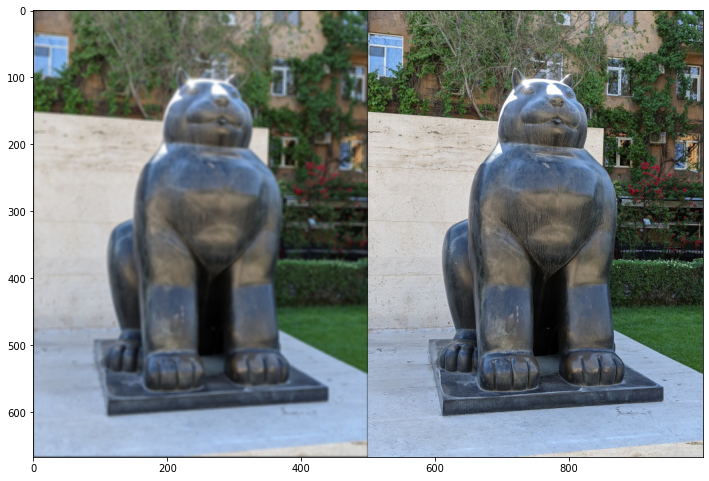

In [ ]:
img_blur = color_convolution(img, kernel_blur)

plt.figure(figsize = (12,10))
plt.imshow(jnp.hstack((img_blur, img)))

In [ ]:
def matrix_filter(channel, kernel):
    filtered_channel = convolve2d(channel, kernel, mode="same")
    filtered_channel = jnp.clip(filtered_channel, 0.0, 1.0)
    return filtered_channel

color_convolution_vmap = jax.vmap(matrix_filter, in_axes=(2, None), out_axes=2)

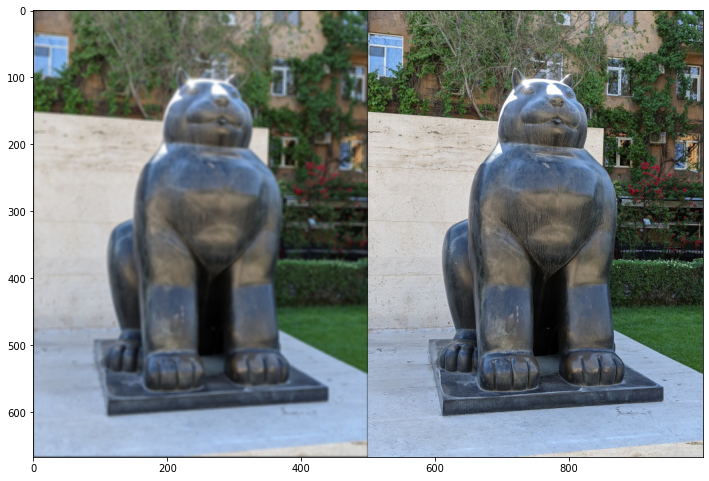

In [ ]:
img_blur = color_convolution_vmap(img, kernel_blur)

plt.figure(figsize = (12,10))
plt.imshow(jnp.hstack((img_blur, img)))

In [ ]:
%timeit color_convolution(img, kernel_blur).block_until_ready()

405 ms ± 2.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit color_convolution_vmap(img, kernel_blur).block_until_ready()

174 ms ± 949 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
color_convolution_jit = jax.jit(color_convolution)
color_convolution_vmap_jit = jax.jit(color_convolution_vmap)

In [ ]:
color_convolution_jit(img, kernel_blur);
color_convolution_vmap_jit(img, kernel_blur);

In [ ]:
%timeit color_convolution_jit(img, kernel_blur).block_until_ready()

337 ms ± 504 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit color_convolution_vmap_jit(img, kernel_blur).block_until_ready()

143 ms ± 724 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
